# Advance Pipeline Land Detection
In the Previous project, Canny edge detection and Hough Transformation have limitations on handling shadows, and the constant threshold would not play well with a constantly changing driving environment. A more robust image process logic is require to get a good lane detecting result

## Road Map to a More Robust Lane Finding Algorithms 
The approach would be shown in the following steps
1. Camera Calibration and Distortion Correction
2. Color and Gradient Threshold Filter
3. Perspective Transform Calculation
4. Sliding Window Lane Line Finding
5. Curvature Measurement


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#glob is used to reading all the similar calbration image
import glob
# import all cal images
cal_images = glob.glob ('camera_cal/calibration*.jpg')

## Camera Calibration
This Camera Calibration only run once. The Camera matrix is save as a global variable.

In [5]:
# Arrays to store object points and image points from all images
objpoints = []
imgpoints = []

# Obj points should not change and only based on the chesss board format
# Preparing object points, like (0,0,0), (1,0,0) ...
objp = np.zeros((6*9,3),np.float32)
 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # Creating x y coordinates

for fname in cal_images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find Chesse board corners
    ret, corners = cv2.findChessboardCorners (gray, (9,6),None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
# Get the Camera matrix 
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,
                                               img.shape[1:],None,None)

# Function use to undistort images
def undistort_img (img,mtx=mtx,dist=dist):
    return cv2.undistort(img,mtx,dist,None,mtx)

## Color and Gradient Threshold Filter
This part of the code is transfered from [parameter_tunning.ipynb](parameter_tunning.ipynb)

In [6]:
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_threshold(gray, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_arctan = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_arctan)
    binary_output[(abs_arctan >= thresh[0]) & (abs_arctan <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def sobel_gradient (image, overdrive = True, ksize = 3,abs_thresh = (25,200),
                    mag_thresh = (40,150),dir_thresh = (0.7,1.3)):
    
    # Convert to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions according to the compliexity
    gradx = abs_sobel_thresh(gray, orient='x', thresh=abs_thresh)
    grady = abs_sobel_thresh(gray, orient='y', thresh=abs_thresh)
    combined = np.zeros_like(grady)
    
    # Choose complexity True means more complicated calculation
    # If min complexity require only execute x and y gradient
    if overdrive: 
        mag_binary = mag_threshold(gray,sobel_kernel=ksize,thresh= mag_thresh)
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=dir_thresh)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    else:
        combined[(gradx == 1) & (grady == 1)] = 1       
        
    return combined
# A function only process h and s channels
def convert_to_hs (image, thresh_h = [18,100], thresh_s = [90,255]):
    
    # First convert image to HLS and only take H and S
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
    # Create Binary arrays
    binary_h = np.zeros_like(H)
    binary_s = np.zeros_like(S)
    
    binary_h[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1
    binary_s[(S >thresh_s[0]) & (S<= thresh_s[1])] = 1
    
    return binary_h, binary_s
    
"""
Image process takes a frame iamge and return a binary image as an input of pipeline logic
Input: 
    image: a RGB image array 
    overdrive: boolean True mean complicated computing include all threshold methods, 
               False means simple computing only S threshold and xy graidents
Return:
    combined_binary: all the threhold binary combined
    color_binary: used to visuallize the two combines binary. Debugging use only
"""
def image_process (image, overdrive = False):
    # Fine tune all the threshold here
    thresh_h = [23,100]
    thresh_s = [170,255]
    thresh_r = [220,255]
    abs_thresh = (50,200)
    mag_thresh = (60,150)

    # Get binary H and S from hls color space
    binary_h, binary_s = convert_to_hs(image,thresh_h = thresh_h, thresh_s = thresh_s)
    combined_binary = np.zeros_like(binary_s)
    
    if overdrive:
        # Grab gradient result 
        gradient_binary = sobel_gradient(image,ksize=15,
                                         abs_thresh=abs_thresh,mag_thresh = mag_thresh)
        
        # Implement R threhold
        R =image[:,:,0]
        
        binary_r = np.zeros_like(R)
        binary_r[(R > thresh_r[0]) & (R <= thresh_r[1])] = 1
        
        # Combine R with H and S threshold binary
        color_thresh_binary = np.zeros_like(binary_s)
        color_thresh_binary[((binary_h == 1) & (binary_s ==1))|(binary_r ==1)] = 1
        
        # Create color binary to visualiize the logic combining
        color_binary = np.dstack((binary_r,color_thresh_binary,gradient_binary))*255
        # Combine all the binary
        combined_binary[(color_thresh_binary ==1)|(gradient_binary ==1)] = 1
    
    else:
        # Grab gradient result 
        gradient_binary = sobel_gradient(image,overdrive=overdrive,abs_thresh=abs_thresh)
        combined_binary[(binary_s ==1)|(gradient_binary ==1)] =1
        color_binary = np.dstack((np.zeros_like(gradient_binary),binary_s,gradient_binary))*255
    
    return combined_binary,color_binary

## Perspective Transform Calculation
Now let's define trapezoid mask and preform perspective transform to an image

[[  20.   680. ]
 [ 562.5  450. ]
 [ 717.5  450. ]
 [1260.   680. ]] 

 [[ 200.  705.]
 [ 200.   40.]
 [1080.   40.]
 [1080.  705.]]


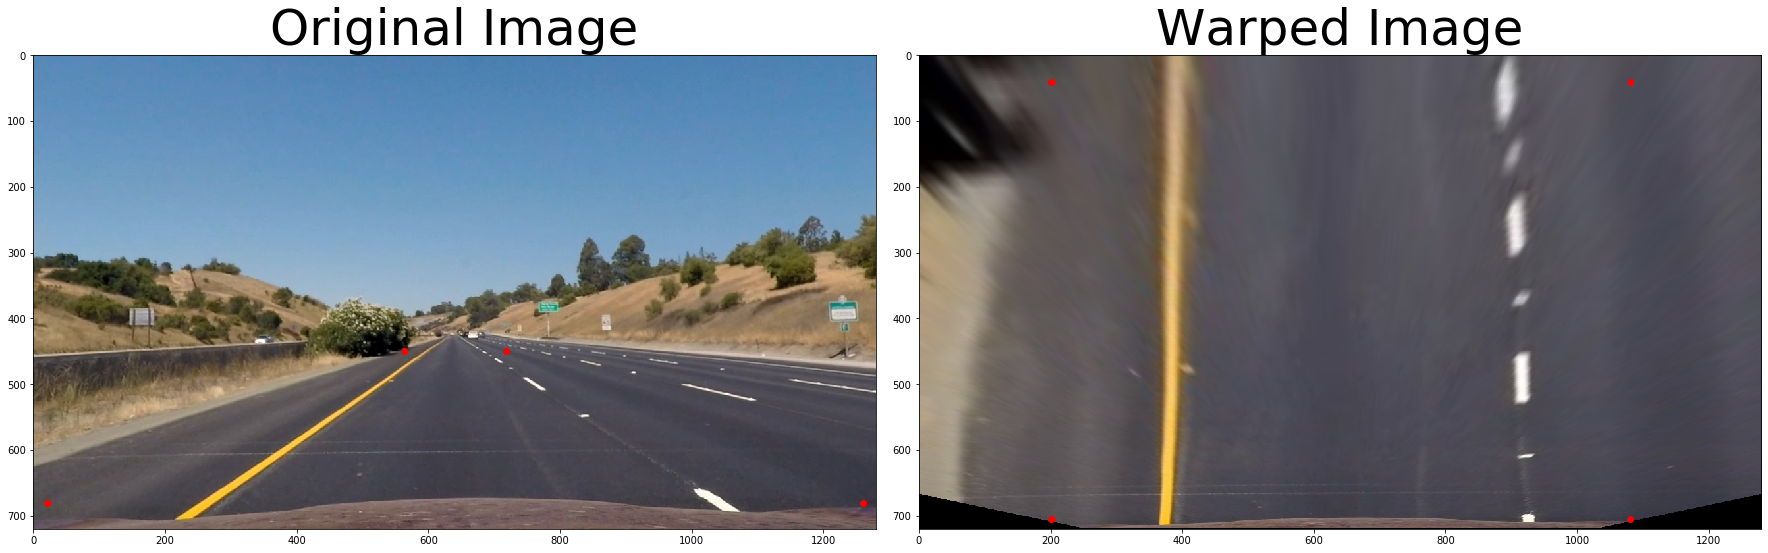

In [247]:
# Define the mask parameters. This function will adjust src and dst coordinates to different 
# size of images

# mask top width is the top width of the trapezoid
# x_offset is the offset on the bottom line X cooridate of the trapezoid
# y_offset is the offset on the bottom line Y cooridtate of the trapzoid
# dst_offset is the destination rectangle X offset 
def mask_image (img,mask_top_width = 155, x_offset = 20, y_offset=40, dst_offset = 200):

    imshape=img.shape
    # Calculate mask height
    img_y_mid = imshape[0]*0.5
    mask_height = int(img_y_mid*1.25)
    img_x_mid = int(imshape[1]*0.5)
    top_left = [img_x_mid - mask_top_width*0.5 , mask_height]
    top_right = [img_x_mid + mask_top_width*0.5 , mask_height]
    bottom_left = [x_offset,imshape[0]-y_offset]
    bottom_right = [imshape[1]-x_offset,imshape[0]-y_offset]

    # Define the source points
    src = np.float32([bottom_left,top_left,top_right,bottom_right])
    # Define destination points
    # 25 is hardcoded to move the lane line to the bottom of the image
    dst = np.float32([[dst_offset, imshape[0]-y_offset+25], [dst_offset, y_offset], 
                                     [imshape[1]-dst_offset, y_offset], 
                                     [imshape[1]-dst_offset, imshape[0]-y_offset+25]])
    return src, dst


# Test using straight lines1 
straight_img = mpimg.imread('test_images/straight_lines1.jpg')
undist_straight = cv2.undistort(straight_img,mtx,dist,None,mtx)

src,dst = mask_image(undist_straight)
    
M = cv2.getPerspectiveTransform(src,dst)
img_size = (undist_straight.shape[1], undist_straight.shape[0])
warped = cv2.warpPerspective(undist_straight,M,img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# prepare src point for scatter plot
x1=[]
y1=[]
for i in src:
    x1.append(i[0])
    y1.append(i[1])
ax1.scatter(x1,y1,color='r')

ax1.imshow(undist_straight)
ax1.set_title('Original Image', fontsize=50)
x2=[]
y2=[]
for i in dst:
    x2.append(i[0])
    y2.append(i[1])
print(src,'\n\n',dst)
ax2.scatter(x2,y2,color='r')
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


After tunning with the test images, I am going to use ` mask_top_width = 155, x_offset = 20, y_offset=40, dst_offset = 200` to get the src and dst coordinates for my Perspective Transform.
## Sliding Window Lane Finding
